In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../DataSets/Human-faces-object-detection/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

DataSets/human-faces-object-detection/faces.csv
DataSets/human-faces-object-detection/images\00000003.jpg
DataSets/human-faces-object-detection/images\00000004.jpg
DataSets/human-faces-object-detection/images\00000005.jpg
DataSets/human-faces-object-detection/images\00000006.jpg
DataSets/human-faces-object-detection/images\00000008.jpg
DataSets/human-faces-object-detection/images\00000011.jpg
DataSets/human-faces-object-detection/images\00000012.jpg
DataSets/human-faces-object-detection/images\00000015.jpg
DataSets/human-faces-object-detection/images\00000018.jpg
DataSets/human-faces-object-detection/images\00000020.jpg
DataSets/human-faces-object-detection/images\00000022.jpg
DataSets/human-faces-object-detection/images\00000023.jpg
DataSets/human-faces-object-detection/images\00000024.jpg
DataSets/human-faces-object-detection/images\00000026.jpg
DataSets/human-faces-object-detection/images\00000031.jpg
DataSets/human-faces-object-detection/images\00000032.jpg
DataSets/human-faces-obj

### Visualising the data¶

In [2]:
dataset = pd.read_csv('DataSets/human-faces-object-detection/faces.csv')

In [3]:
dataset.head()

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


### Human Face Detection using a Convolutional Neural Network

### Importing required libraries

In [4]:
import warnings
warnings.filterwarnings("ignore")
import os
import pathlib
import PIL
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
import cv2 as cv
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense,Dropout, BatchNormalization

### Visualising the data

In [5]:
dataset = pd.read_csv('DataSets/human-faces-object-detection/faces.csv')

In [6]:
dataset.head()

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


In [7]:
data = {}
for i in dataset["image_name"]:
    if i not in data:
        data[i] = []
for index, img_name in enumerate(dataset["image_name"]):
    width = dataset["width"][index]
    height = dataset["height"][index]
    x0 = dataset["x0"][index]
    x1 = dataset["x1"][index]
    y0 = dataset["y0"][index]
    y1 = dataset["y1"][index]

    new_x0 = int((x0/width)*224)
    new_x1 = int((x1/width)*224)
    new_y0 = int((y0/width)*224)
    new_y1 = int((y1/width)*224)

    data[img_name].append(new_x0)
    data[img_name].append(new_x1)
    data[img_name].append(new_y0)
    data[img_name].append(new_y1)

In [8]:
for dirpath, dirnames, filenames in os.walk("DataSets"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 16 directories and 30 images in 'DataSets'.
There are 0 directories and 1 images in 'DataSets\AI Survey'.
There are 0 directories and 1 images in 'DataSets\Cancer Patients Data Analysis'.
There are 0 directories and 1 images in 'DataSets\Corona'.
There are 0 directories and 1 images in 'DataSets\Decision_tree'.
There are 0 directories and 1 images in 'DataSets\EDA on IMDB Dataset'.
There are 0 directories and 1 images in 'DataSets\Fatty Liver - Decision Tree Investigations'.
There are 3 directories and 0 images in 'DataSets\Fruit'.
There are 1 directories and 0 images in 'DataSets\Fruit\fruit_photos'.
There are 0 directories and 159 images in 'DataSets\Fruit\fruit_photos\Apple Braeburn'.
There are 1 directories and 0 images in 'DataSets\Fruit\test'.
There are 0 directories and 1358 images in 'DataSets\Fruit\test\test'.
There are 1 directories and 0 images in 'DataSets\Fruit\train'.
There are 3 directories and 0 images in 'DataSets\Fruit\train\train'.
There are 0 directories a

In [9]:
img_dir = os.listdir('DataSets/human-faces-object-detection/images')
images = []
for img_name in data.keys():
    for itr in img_dir:
        if img_name == itr:
            img_arr = cv.imread(os.path.join('DataSets/human-faces-object-detection/images', img_name), cv.IMREAD_GRAYSCALE)
            img_resize = cv.resize(img_arr, (224, 224))
            images.append(img_resize)
images

[array([[224, 225, 225, ..., 224, 224, 223],
        [224, 225, 225, ..., 224, 224, 224],
        [225, 225, 225, ..., 224, 224, 225],
        ...,
        [234, 234, 234, ..., 234, 234, 234],
        [234, 234, 234, ..., 234, 234, 234],
        [234, 234, 234, ..., 234, 234, 234]], dtype=uint8),
 array([[68, 68, 66, ..., 49, 50, 50],
        [68, 69, 68, ..., 49, 49, 51],
        [68, 68, 70, ..., 49, 49, 50],
        ...,
        [22, 22, 22, ..., 16, 16, 16],
        [22, 22, 22, ..., 16, 16, 16],
        [21, 21, 21, ..., 15, 15, 15]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [3, 3, 3, ..., 5, 4, 4],
        [3, 3, 3, ..., 5, 5, 4],
        [3, 3, 3, ..., 4, 4, 4]], dtype=uint8),
 array([[242, 242, 242, ..., 246, 246, 245],
        [242, 242, 242, ..., 246, 246, 246],
        [242, 242, 242, ..., 246, 246, 246],
        ...,
        [243, 243, 243, ..., 246, 246, 246],
        [243, 243, 24

In [10]:
images = np.array(images)
images = np.expand_dims(images, axis = 3)

In [11]:
print(f"Shape of images : {images.shape}")

Shape of images : (2204, 224, 224, 1)


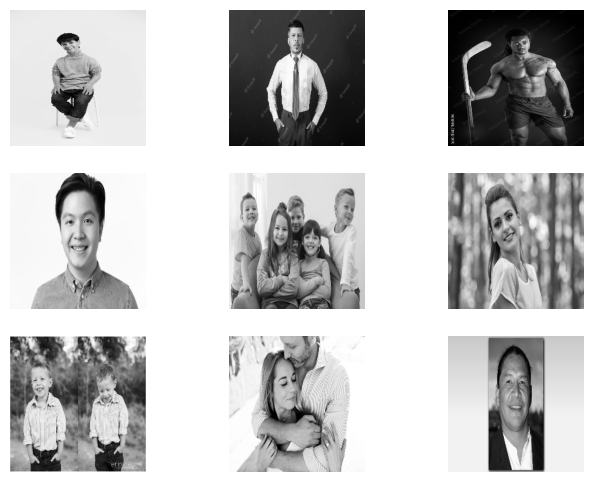

In [12]:
plt.figure(figsize = (8,6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i], cmap = 'gray')
    plt.axis('off')

### Creating BBoxes (or Bounding Boxes) for Object Detection

In [13]:
bbox = []
for box in data.keys():
    bbox.append(data[box])

In [14]:
max_bbox = 0
for i in range(len(bbox)):
    max_bbox = max(max_bbox, len(bbox[i]))

In [15]:
for i in range(len(bbox)):
    if int(max_bbox) - len(bbox[i]) != 0:
        for j in range(int(max_bbox) - len(bbox[i])):
            bbox[i].append(0)

In [16]:
bbox = np.array(bbox)
bbox[0]

array([ 82, 115,  53, 111,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

bbox = np.array(bbox)
bbox[0]

In [17]:
bbox.shape

(2204, 48)

### Normalisation of image data and bboxes

In [18]:
images = images/255
bbox = bbox/224

### Splitting the data into training and test sets¶

In [19]:
X_train, X_test, y_train, y_test = train_test_split(images, bbox, test_size = 0.25, random_state = 42)

### Building a CNN Sequential Model

In [20]:
model = Sequential([
    Conv2D(32, 3, input_shape = (224,224,1), padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(64, 3, padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(128, 3, padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(256, 3, padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(48, activation = 'sigmoid') #output layer has 48 neurons to match the bbox dimensions
])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [22]:
#Adapted from the PyImageSearch article on Object Detection with Keras and TensorFlow
#https://pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/

class obj_detect_callback(keras.callbacks.Callback):
    def epoch_end(self, epoch, logs = {}):
        prediction = model.predict(X_test[0].reshape(1,224,224,1))
        fig, ax = plt.subplots(1)
        ax.imshow(X_test[0])
        x1 = int(prediction[0][0]*224)
        y1 = int(prediction[0][1]*224)
        x2 = int(prediction[0][2]*224)
        y2 = int(prediction[0][3]*224)
        rect = matplotlib.patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth = 1, edgecolor = 'r', facecolor = 'none')
        ax.add_patch(rect)
        plt.show()

In [23]:
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [24]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, callbacks = [obj_detect_callback()])

Epoch 1/50
52/52 [==============================] - 49s 932ms/step - loss: 0.2415 - accuracy: 0.4834 - val_loss: 0.1311 - val_accuracy: 0.6806
Epoch 2/50
52/52 [==============================] - 47s 900ms/step - loss: 0.1265 - accuracy: 0.6316 - val_loss: 0.1314 - val_accuracy: 0.6806
Epoch 3/50
52/52 [==============================] - 50s 957ms/step - loss: 0.1245 - accuracy: 0.6854 - val_loss: 0.1238 - val_accuracy: 0.6806
Epoch 4/50
52/52 [==============================] - 46s 886ms/step - loss: 0.1228 - accuracy: 0.6848 - val_loss: 0.1238 - val_accuracy: 0.6806
Epoch 5/50
52/52 [==============================] - 48s 921ms/step - loss: 0.1223 - accuracy: 0.6842 - val_loss: 0.1248 - val_accuracy: 0.6806
Epoch 6/50
52/52 [==============================] - 48s 928ms/step - loss: 0.1211 - accuracy: 0.6848 - val_loss: 0.1228 - val_accuracy: 0.6806
Epoch 7/50
52/52 [==============================] - 47s 904ms/step - loss: 0.1212 - accuracy: 0.6836 - val_loss: 0.1224 - val_accuracy: 0.6806

In [25]:
# Adapted from Daniel Bourke's Course on TensorFlow and Deep Learning
def plot_loss_curves(history):
    '''
    Returns separate loss curves for training and validation metrics
    '''
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss'])) #generates the sequence of indices in a list, in this case epochs

    #Plot loss
    plt.plot(epochs, loss, label = 'training loss')
    plt.plot(epochs, val_loss, label = 'val_loss')
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.legend()

    #Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label = 'training accuracy')
    plt.plot(epochs, val_accuracy, label = 'val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

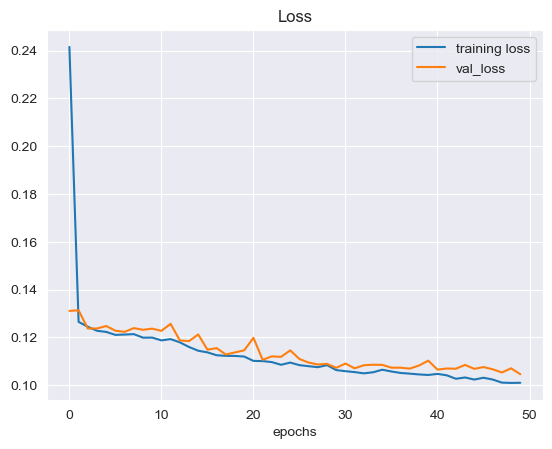

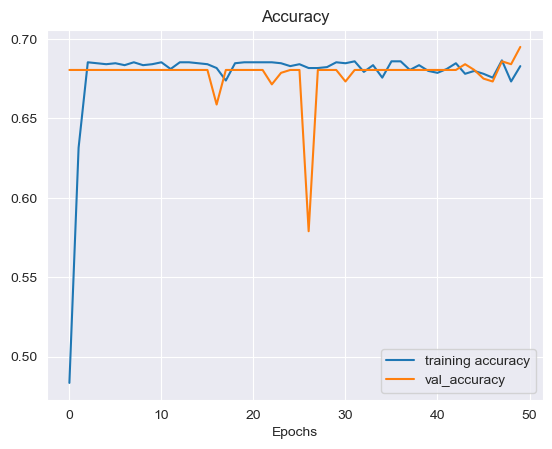

In [26]:
plot_loss_curves(history)

In [27]:
model.evaluate(X_test, y_test, batch_size = 32)

18/18 [==============================] - 3s 180ms/step - loss: 0.1046 - accuracy: 0.6951


[0.10463132709264755, 0.6950998306274414]

### Model 2: Adding a BatchNormalisation and Dropout Layer¶

The Dropout Layer will set input unit frequencies to 0 at any point during training. Overfitting is thus prevented.

In [28]:
model_2 = Sequential([
    Conv2D(32, 3, input_shape = (224,224,1), activation = 'relu'),
    Dropout(0.1),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(64, 3, activation = 'relu'),
    Dropout(0.2),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(128, 3, activation = 'relu'),
    Dropout(0.3),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(256, 3, activation = 'relu'),
    Dropout(0.4),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    Dense(48, activation = 'sigmoid') #output layer
])

In [29]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 dropout (Dropout)           (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout_1 (Dropout)         (None, 109, 109, 64)     

In [30]:
model_2.compile(loss = 'binary_crossentropy',
                optimizer= tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
history_2 = model_2.fit(X_train, y_train, validation_data = (X_test, y_test),
                        batch_size = 8, epochs = 60, callbacks = [obj_detect_callback()])

Epoch 1/60
136/207 [==================>...........] - ETA: 27s - loss: 0.1690 - accuracy: 0.6415

In [ ]:
plot_loss_curves(history_2)

In [ ]:
model_2.evaluate(X_test, y_test, batch_size = 32)

In [ ]:
def plot_predictions(model,idx):
    '''
    Plots the decision boundary for a model on an image specified by its index.

    Parameters:

    model: The model whose predictions we are testing
    idx: The index of the image as it appears in the dataset
    '''
    model_prediction = model.predict(X_test[idx].reshape(1, 224, 224, 1))
    model_prediction = model_prediction[0]
    img = X_test[idx]
    count = 0
    bbox1 = []
    for i in model_prediction:
        bbox1.append(i)
        count+=1
        if count == 4:
            count = 0
            plt.subplot(1,2,1)
            plt.imshow(img)
            x1 = int(bbox1[0]*224)
            y1 = int(bbox1[1]*224)
            x2 = int(bbox1[2]*224)
            y2 = int(bbox1[3]*224)
            plt.gca().add_patch(matplotlib.patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1,
                                                             edgecolor = 'r', facecolor = "none"))
            bbox1 = []
    plt.show()

In [ ]:
plot_predictions(model,4)

In [ ]:
plot_predictions(model_2, 4)